In [ ]:
#%% packages

from scipy.stats import spearmanr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multitest import multipletests

In [ ]:
#%% function

def correlate_two_rsms(rsm1, rsm2, n_permutation=1000, if_display=True):
    """Compute correlation between two RSMs with permutation testing
    Args:
        rsm1 (np.ndarray): First RSM
        rsm2 (np.ndarray): Second RSM
        n_permutation (int): Number of permutations for null distribution
        if_display (bool): Whether to display null distribution plot
    Returns:
        tuple: (correlation coefficient, permutation p-value)
    """
    # Get lower triangular indices
    tril_idx = np.tril_indices_from(rsm1, k=-1)
    
    vec1 = rsm1[tril_idx]
    vec2 = rsm2[tril_idx]
    
    # Compute observed correlation
    observed_r, _ = spearmanr(vec1, vec2)
    
    # Permutation test
    null_dist = np.zeros(n_permutation)
    for i in range(n_permutation):
        # Shuffle first RSM by row
        perm_idx = np.random.permutation(len(vec1))
        null_dist[i], _ = spearmanr(vec1[perm_idx], vec2)

    # Compute two-tailed p-value
    p_value = (1 + np.sum(np.abs(null_dist) >= np.abs(observed_r))) / (1 + n_permutation)
    
    if if_display:
        plt.figure(figsize=(10,6))
        plt.hist(null_dist, bins=50, edgecolor='black')
        plt.axvline(x=observed_r, color='r', linestyle='--')
        plt.title('Null Distribution of Correlations', fontsize=22)
        plt.xlabel('Correlation Coefficient', fontsize=18)
        plt.ylabel('Frequency', fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.annotate(f'r = {observed_r:.3f}\np = {p_value:.3f}', 
                    xy=(0.7, 0.8), xycoords='axes fraction', 
                    fontsize=18)
        plt.show()
        
    return observed_r, p_value

def correlate_dicts_asymmetric(reference_dict, candidate_dict_dict, n_permutation=1000, multiple_comparison='fdr_bh'):
    """Compute correlations between all pairs of RSMs from two dictionaries
    Args:
        reference_dict (dict): First dictionary with RSM names as keys and RSMs as values
        candidate_dict_dict (dict): Dictionary of dictionaries, where each inner dictionary contains RSM names as keys and RSMs as values
        n_permutation (int): Number of permutations for null distribution
        multiple_comparison (str): Multiple comparison correction method ('fdr_bh' or 'bonferroni')
    Returns:
        pd.DataFrame: DataFrame with correlation results including adjusted p-values and significance
    """
    # Initialize lists to store results
    results = []
    
    # Iterate through each module in candidate_dict_dict
    for module, candidate_dict in candidate_dict_dict.items():
        # Compute correlations for all pairs within this module
        for key1, rsm1 in reference_dict.items():
            for key2, rsm2 in candidate_dict.items():
                #print(f"{key1} - {module}_{key2}")
                r, p = correlate_two_rsms(rsm1, rsm2, n_permutation=n_permutation, if_display=False)
                results.append({
                    'reference': key1,
                    'candidate': key2,
                    'module': module,
                    'r': r,
                    'p': p
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Apply multiple comparison correction
    _, p_adj, _, _ = multipletests(df['p'], method=multiple_comparison)
    df['q'] = p_adj
    
    # Add significance symbols
    def get_sig_symbol(p):
        if p > 0.05:
            return 'n.s.'
        elif p > 0.01:
            return '*'
        elif p > 0.001:
            return '**'
        else:
            return '***'
    
    df['sig_sign'] = df['q'].apply(get_sig_symbol)
    
    return df

def plot_heatmap_asymmetric(correlation_df, candidate_name = "Candidate RSM", reference_name = "Neural RSM (by ROI)", figsize=(10,10)):
    """Plot correlation matrix with significance markers
    Args:
        correlation_df (pd.DataFrame): DataFrame from correlate_two_dicts
        figsize (tuple): Figure size
    """
    def pivot_correlation_df(correlation_df, value_col):
        """Create pivot tables for correlation values and significance markers, with columns grouped by module
        """

        sorted_df = correlation_df.sort_values('module')
        
        ordered_refs = np.sort(sorted_df['reference'].unique())
        ordered_cands = sorted_df['candidate'].unique()
        
        matrix = sorted_df.pivot(
            index='reference',
            columns='candidate',
            values=value_col
        )
        
        matrix = matrix.reindex(columns=ordered_cands)
        matrix = matrix.reindex(index=ordered_refs)
        
        return matrix
    
    matrix = pivot_correlation_df(correlation_df, 'r')
    sig_matrix = pivot_correlation_df(correlation_df, 'sig_sign')
    
    plt.figure(figsize=figsize)
    scale_length=0.5
    
    # Get module boundaries
    modules = correlation_df['module'].unique()
    module_boundaries = []
    current_pos = 0
    for module in modules:
        module_cols = correlation_df[correlation_df['module'] == module]['candidate'].nunique()
        current_pos += module_cols
        if current_pos < len(matrix.columns):  
            module_boundaries.append(current_pos)
    
    # Plot heatmap
    g = sns.heatmap(matrix, cmap='RdBu_r', center=0, vmin=-scale_length, vmax=scale_length,
                annot=False, fmt='.2f', cbar_kws={'label': 'Correlation'})
    cbar = g.collections[0].colorbar
    cbar.set_label('Spearman Correlation', fontsize=20)
    cbar.ax.tick_params(labelsize=20)
    
    # Add white lines between modules
    for boundary in module_boundaries:
        plt.axvline(x=boundary, color='white', linewidth=2)
    # Add significance markers
    for i in range(len(matrix.index)):
        for j in range(len(matrix.columns)):
            if sig_matrix.iloc[i,j] != 'n.s.':
                plt.text(j+0.5, i+0.3, sig_matrix.iloc[i,j],
                        ha='center', va='center', color='black',
                        fontsize=12)
    
    #plt.title('RSM Correlations', fontsize=24)
    plt.xlabel(candidate_name, fontsize=22)
    plt.ylabel(reference_name, fontsize=22)
    plt.xticks(fontsize=18, rotation=90)
    plt.yticks(fontsize=18, rotation=0)

    
    plt.tight_layout()
    plt.show()

def correlate_self(dict_dict, n_permutation=1000, multiple_comparison='fdr_bh', if_display=True, figsize=(10,10), scale_length=0.5):
    """
    Compute correlations between all pairs of RSMs within a dictionary of dictionaries
    
    Args:
        dict_dict (dict): Dictionary of dictionaries containing RSMs
        n_permutation (int): Number of permutations for null distribution
        multiple_comparison (str): Multiple comparison correction method
        if_display (bool): Whether to display correlation heatmap
        figsize (tuple): Figure size for heatmap
        
    Returns:
        tuple: (correlation DataFrame, correlation matrix ordered by modules)
    """
    # Compute all correlations
    results = []
    for module1, dict1 in dict_dict.items():
        for module2, dict2 in dict_dict.items():
            for key1, rsm1 in dict1.items():
                for key2, rsm2 in dict2.items():
                    r, p = correlate_two_rsms(rsm1, rsm2, 
                                            n_permutation=n_permutation, 
                                            if_display=False)
                    results.append({
                        'module': module1,
                        'reference': f"{module1}~{key1}",
                        'candidate': f"{module2}~{key2}",
                        'r': r,
                        'p': p
                    })
    
   
    df = pd.DataFrame(results)
    #  multiple comparison correction
    _, p_adj, _, _ = multipletests(df['p'], method=multiple_comparison)
    df['q'] = p_adj
    
    # Add significance symbols
    df['sig'] = pd.cut(df['q'], 
                       bins=[-np.inf, 0.001, 0.01, 0.05, np.inf],
                       labels=['***', '**', '*', 'n.s.'])
    def create_ordered_matrix(df, value_col):
        """
        Create an ordered correlation matrix from a DataFrame with module-based indices
        """
        # Get module-ordered list of all RSMs
        ordered_rsms = []
        for module in dict_dict.keys():
            module_rsms = [f"{module}~{key}" for key in dict_dict[module].keys()]
            ordered_rsms.extend(sorted(module_rsms))
            
        # Create and reorder matrix
        matrix = df.pivot(index='reference', columns='candidate', values=value_col)
        matrix = matrix.reindex(index=ordered_rsms, columns=ordered_rsms)
        
        # Remove module names from index/columns
        new_index = [x.split('~', 1)[1] for x in matrix.index]
        new_columns = [x.split('~', 1)[1] for x in matrix.columns]
        matrix.index = new_index
        matrix.columns = new_columns
        
        return matrix
        
    # Create ordered matrices
    matrix = create_ordered_matrix(df, 'r')
    sig_matrix = create_ordered_matrix(df, 'sig')
    
    if if_display:
        plt.figure(figsize=figsize)
        
        # Plot heatmap
        g = sns.heatmap(matrix, cmap='RdBu_r', center=0, vmin=-scale_length, vmax=scale_length,
                   annot=False, fmt='.2f', cbar_kws={'label': 'Correlation'})
        
        # Customize colorbar
        cbar = g.collections[0].colorbar
        cbar.set_label('Spearman Correlation', fontsize=20)
        cbar.ax.tick_params(labelsize=20)
  
        
        # Add module boundaries
        current_pos = 0
        for module in dict_dict.keys():
            current_pos += len(dict_dict[module])
            if current_pos < len(matrix):
                plt.axhline(y=current_pos, color='white', linewidth=2)
                plt.axvline(x=current_pos, color='white', linewidth=2)
        
        # Add significance markers
        for i in range(len(matrix)):
            for j in range(len(matrix)):
                if sig_matrix.iloc[i,j] != 'n.s.':
                    plt.text(j+0.5, i+0.5, sig_matrix.iloc[i,j],
                            ha='center', va='bottom', color='black',
                            fontsize=8)
        
        #plt.title('RSM Correlations', fontsize=24)
        plt.xlabel('RSMs', fontsize=22)
        plt.ylabel('RSMs', fontsize=22)
        plt.xticks(rotation=90, ha='right', fontsize=20)
        plt.yticks(rotation=0, fontsize=20)
        plt.tight_layout()
        plt.show()
    
    return df, matrix

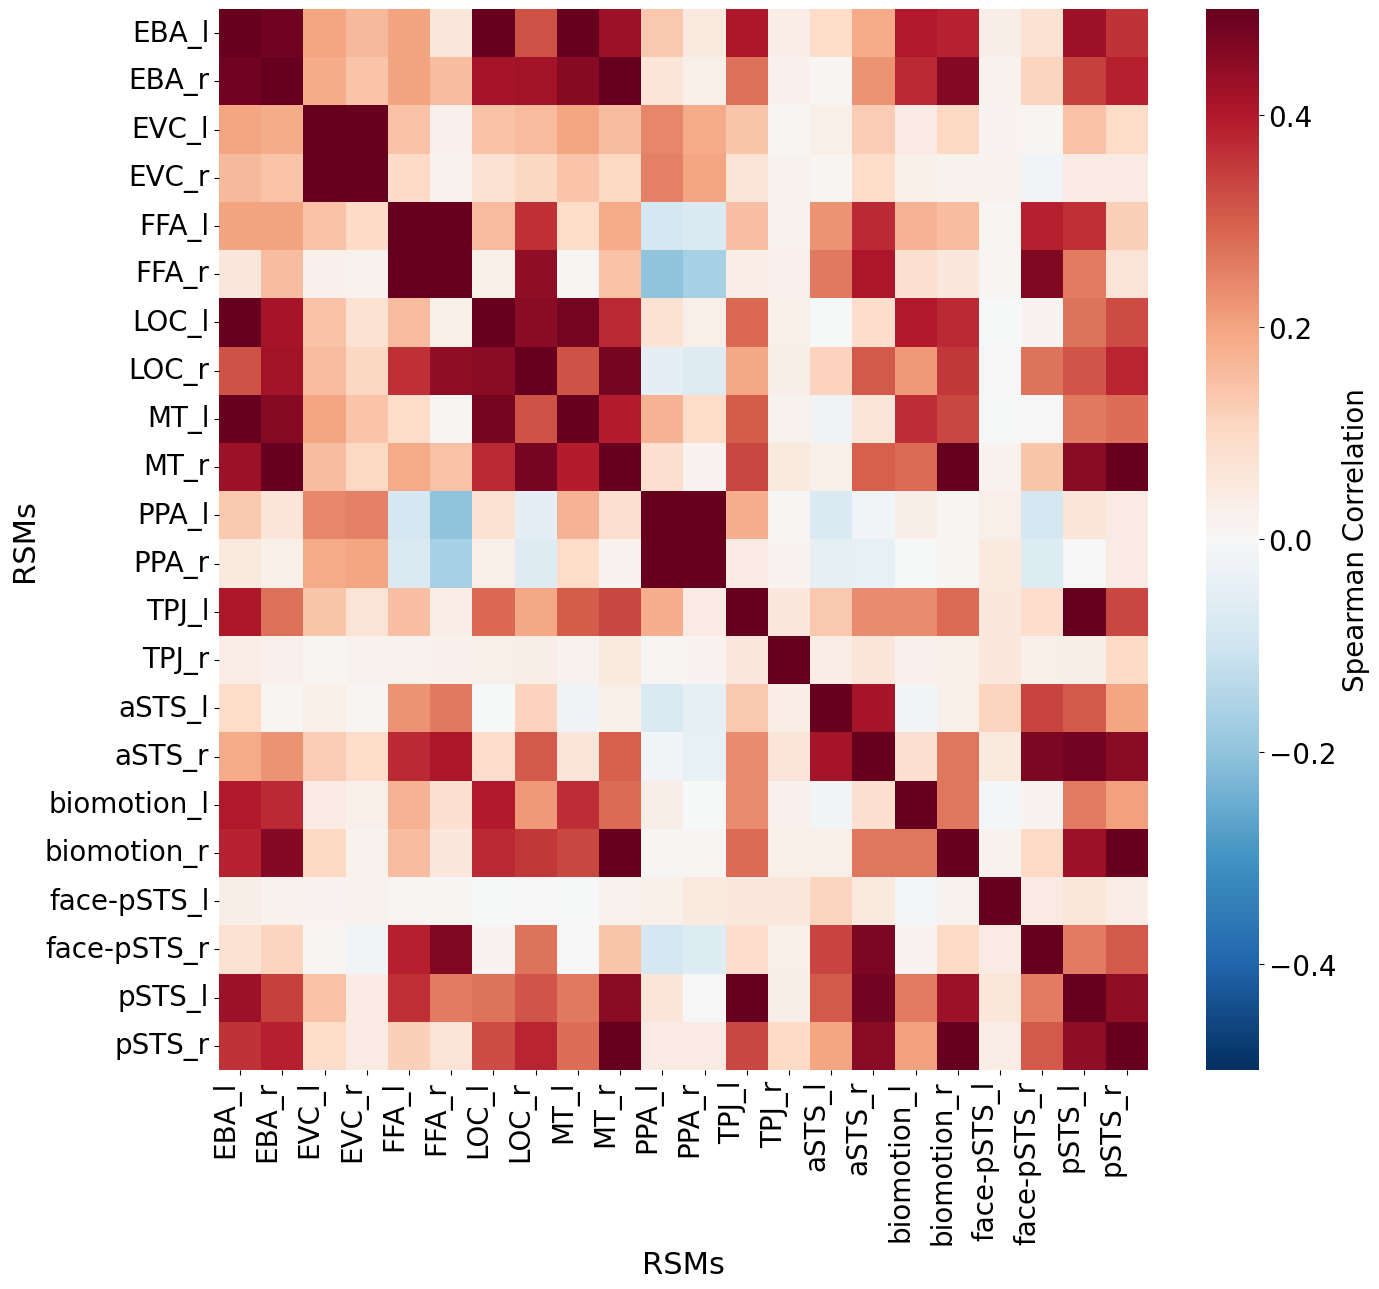

In [ ]:
#%% load neural rsm

neural_rsm=np.load('../data/RSA/neural_rsm.npy',allow_pickle=True).item()

# reorganize neural RSM to combine roi and side
roi_neural_rsm = {}

# Process each subject/group level
for level in neural_rsm.keys():
    roi_neural_rsm[level] = {}
    
    # For each ROI
    for roi in neural_rsm[level].keys():
        # For each side
        for side in neural_rsm[level][roi].keys():
            # Create new key combining side and ROI
            new_key = f'{roi}_{side}'
            roi_neural_rsm[level][new_key] = neural_rsm[level][roi][side]

_,_ = correlate_self({"neural":roi_neural_rsm['sub01']}, n_permutation=0, multiple_comparison='fdr_bh', if_display=True, figsize=(14,13))

dict_keys(['resnet3d50', 'resnet50', 'multi_resnet3d50', 'CLIP'])
dict_keys(['emotion', 'relationship', 'fishing', 'cooking', 'instrument', 'sport', 'dance', 'activity', 'childcare', 'face_orientation', 'communication_modality', 'body_orientation', 'demographics', 'age', 'context', 'outdoors', 'joint_action', 'Transitivity', 'social_distance', 'scene'])


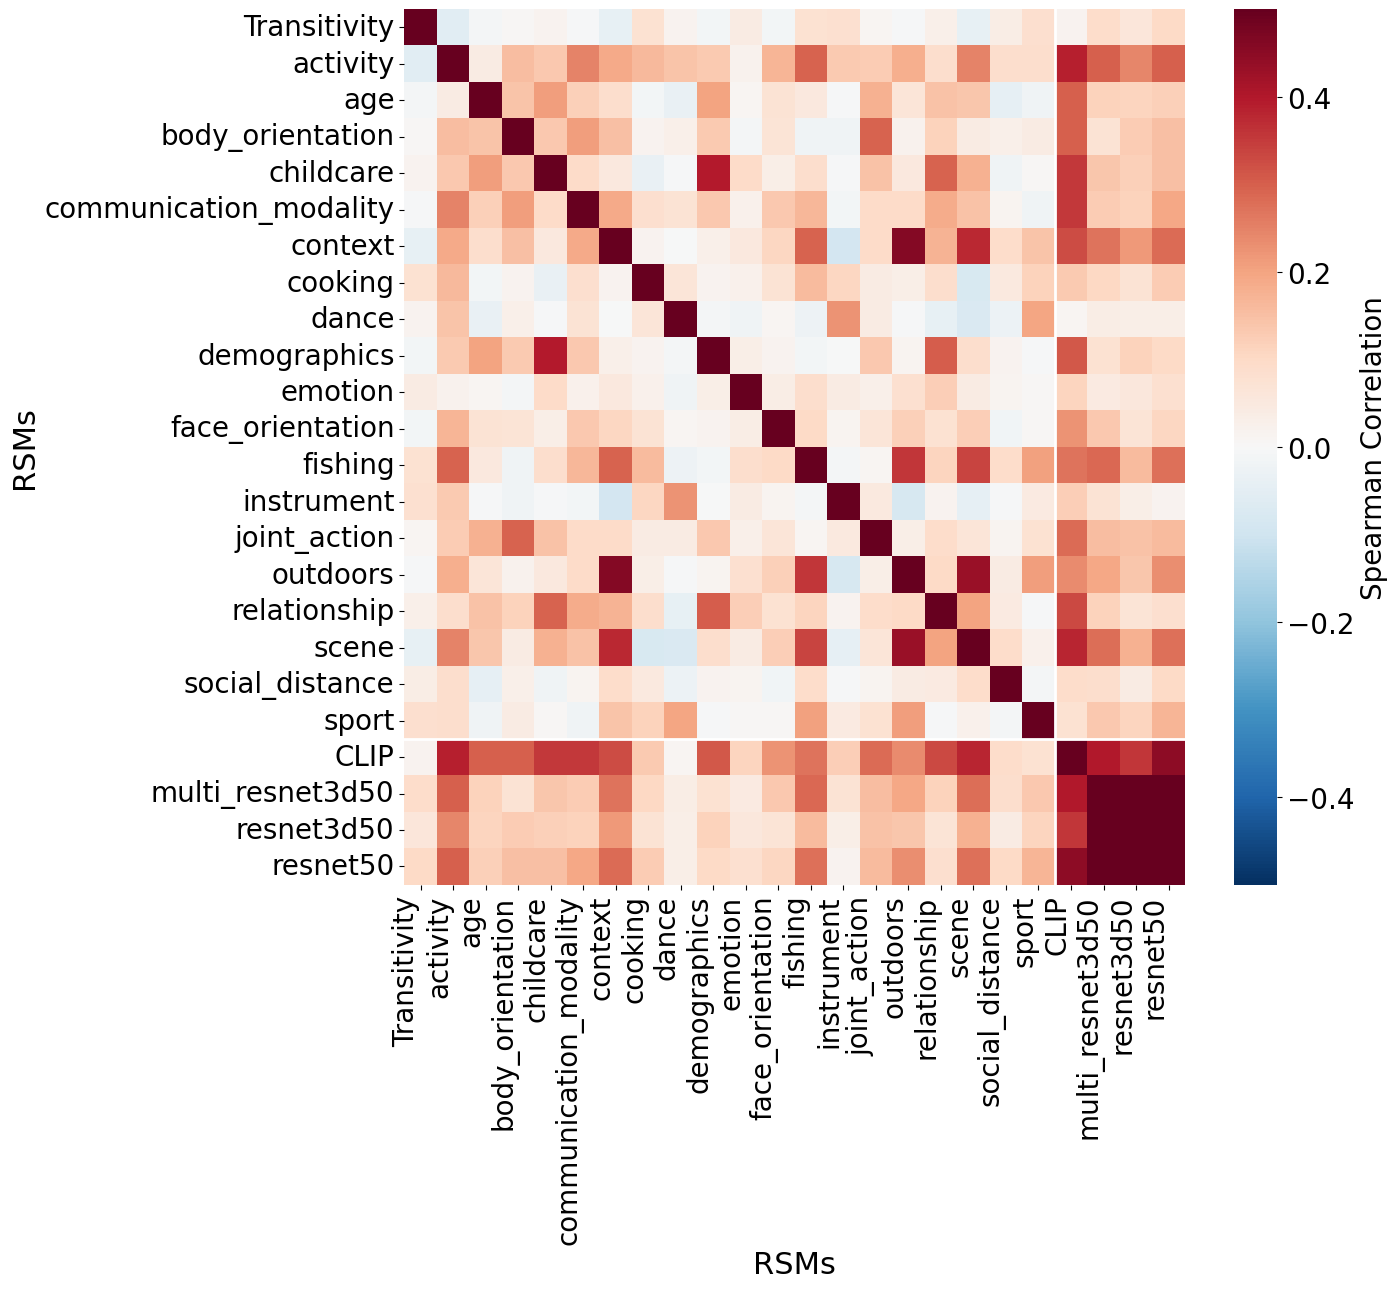

In [ ]:
#%% load model and clip rsm

# model rsm
model_rsm=np.load('../data/RSA/model_rsm.npy',allow_pickle=True).item()
print(model_rsm.keys())
# CLIP RSM
clip_rsm=np.load('../data/RSA/clip_rsm.npy',allow_pickle=True).item()
print(clip_rsm.keys())
# Combine all RSMs into one dictionary
combined_rsm = {"CLIP_annotation":clip_rsm, "model_embedding":model_rsm}
_,_ = correlate_self(combined_rsm, n_permutation=0, multiple_comparison='fdr_bh', if_display=True, figsize=(14,13))

group

Correlating group with combined RSM:


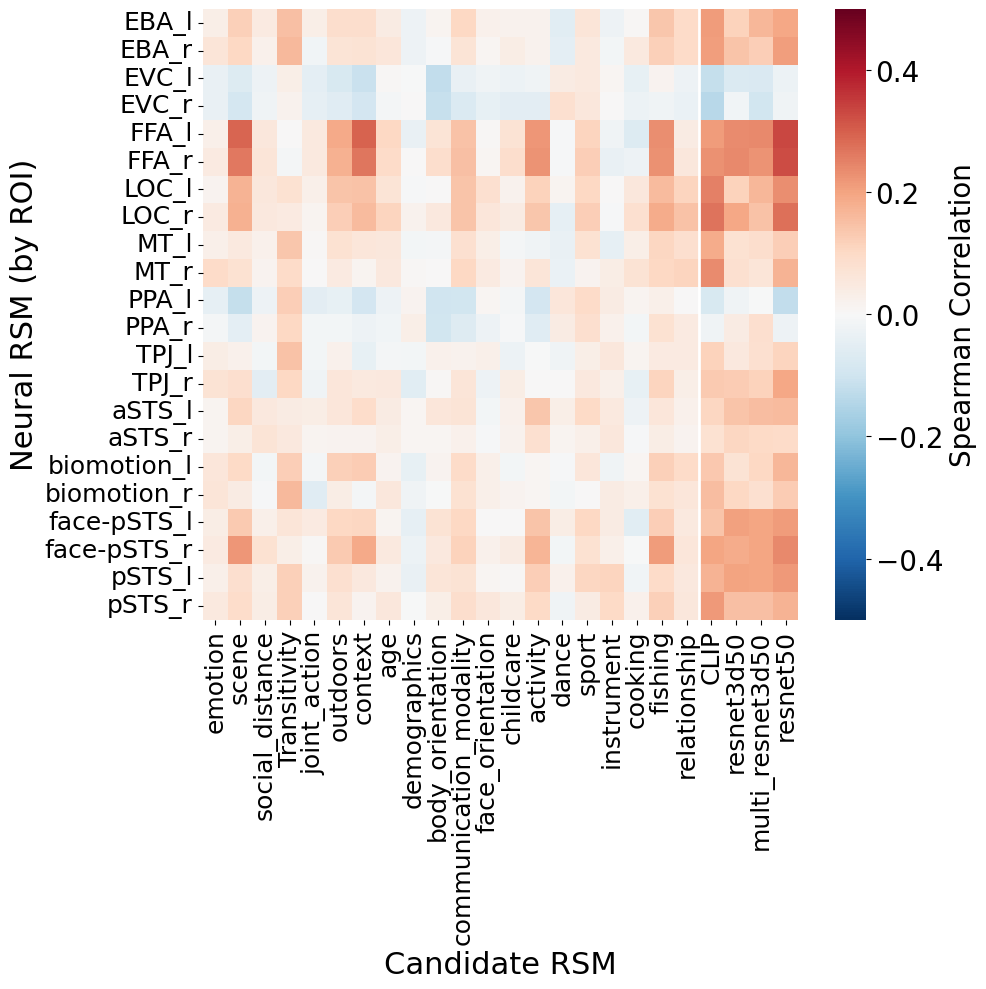

sub01

Correlating sub01 with combined RSM:


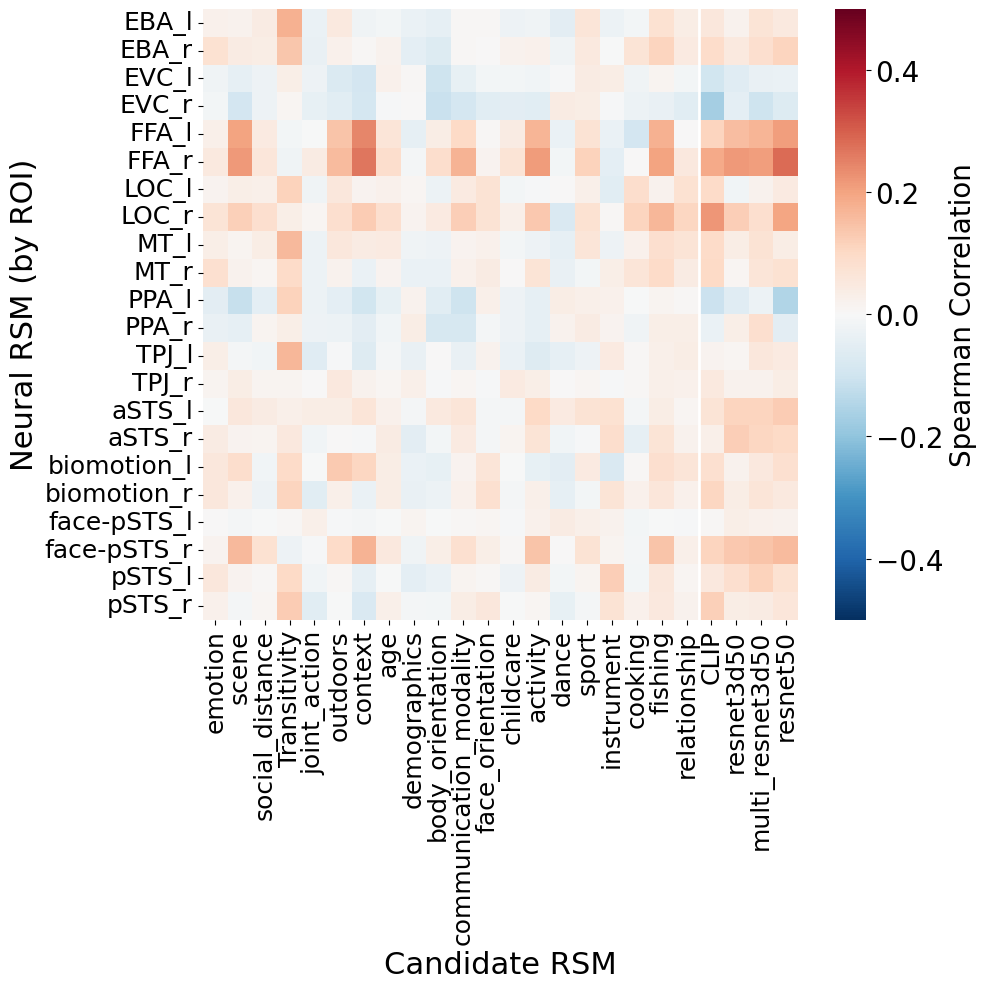

sub02

Correlating sub02 with combined RSM:


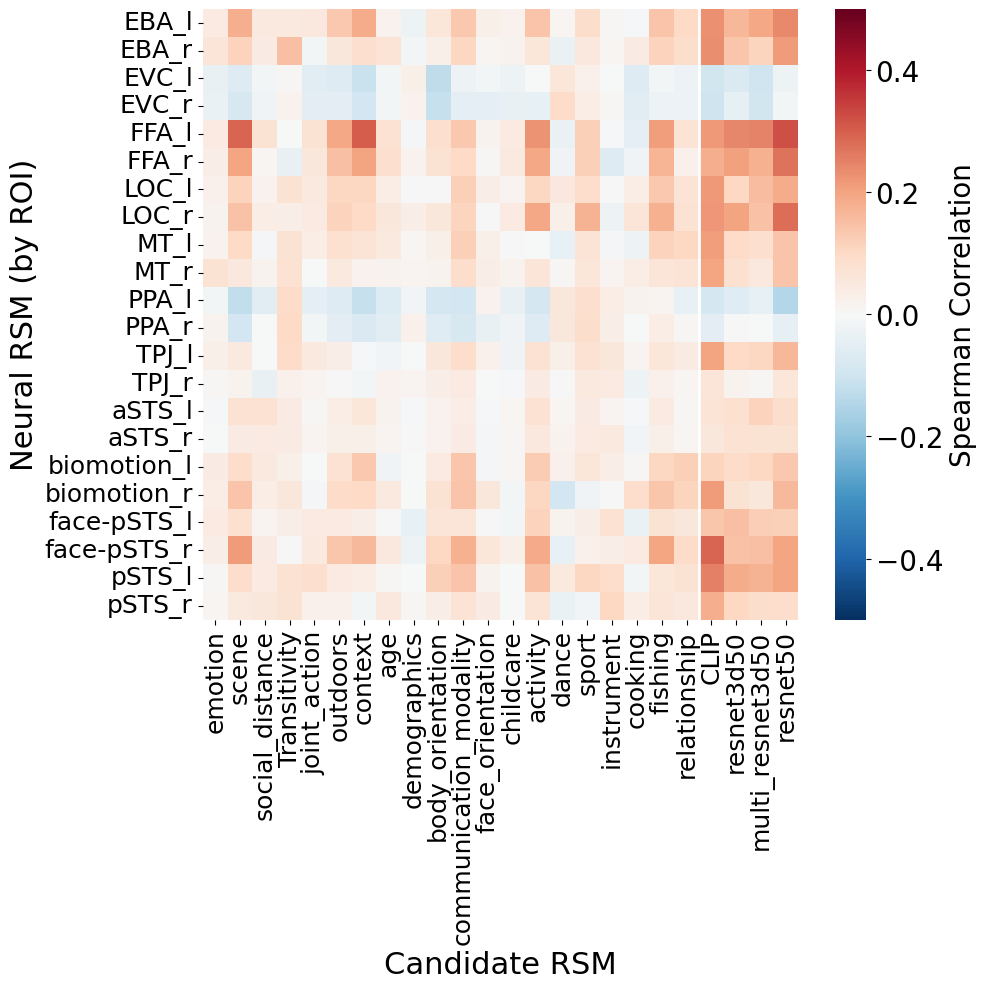

sub03

Correlating sub03 with combined RSM:


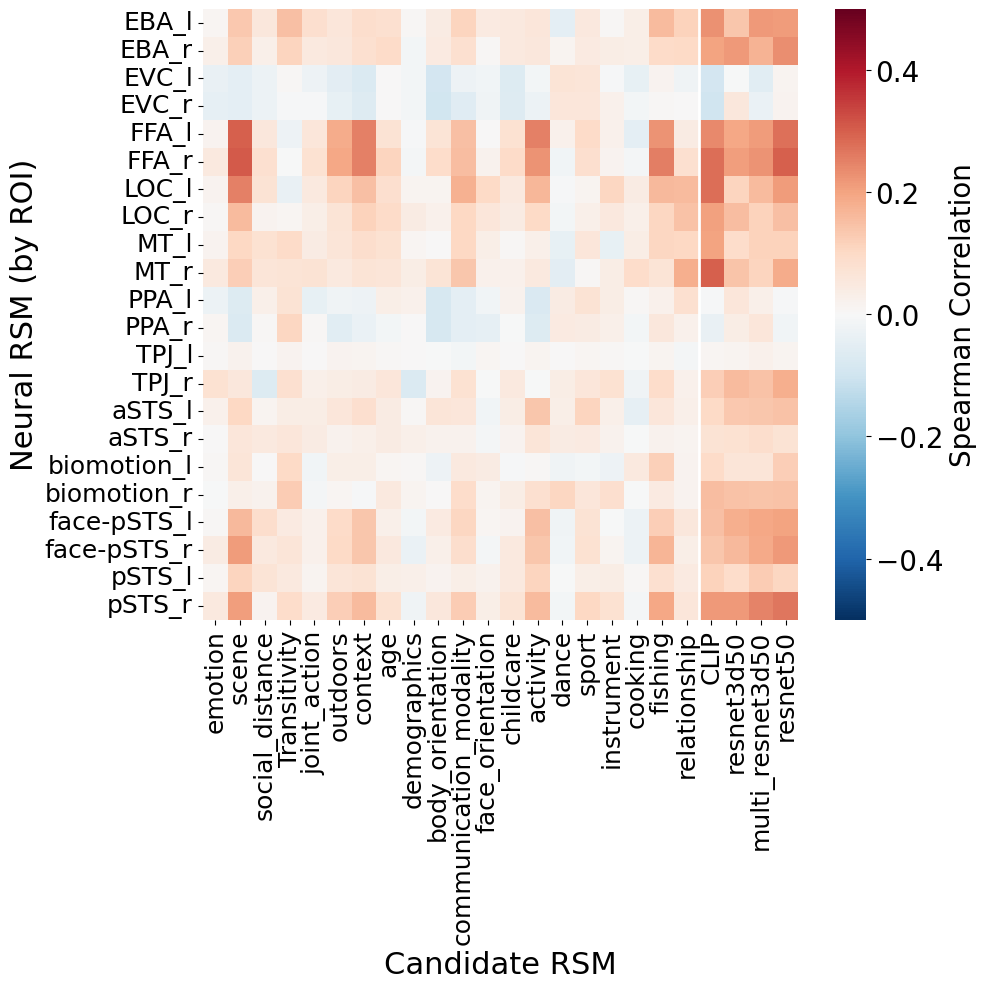

sub04

Correlating sub04 with combined RSM:


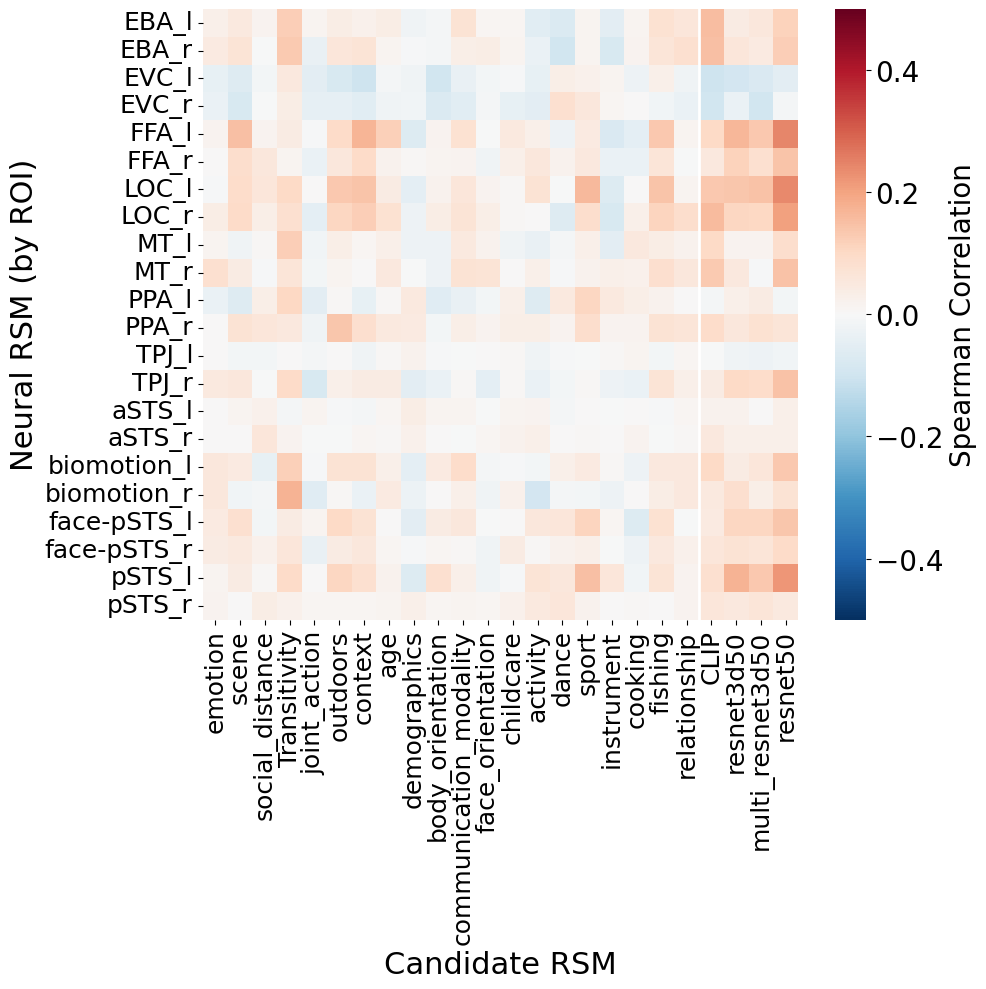


Average correlation across subjects:


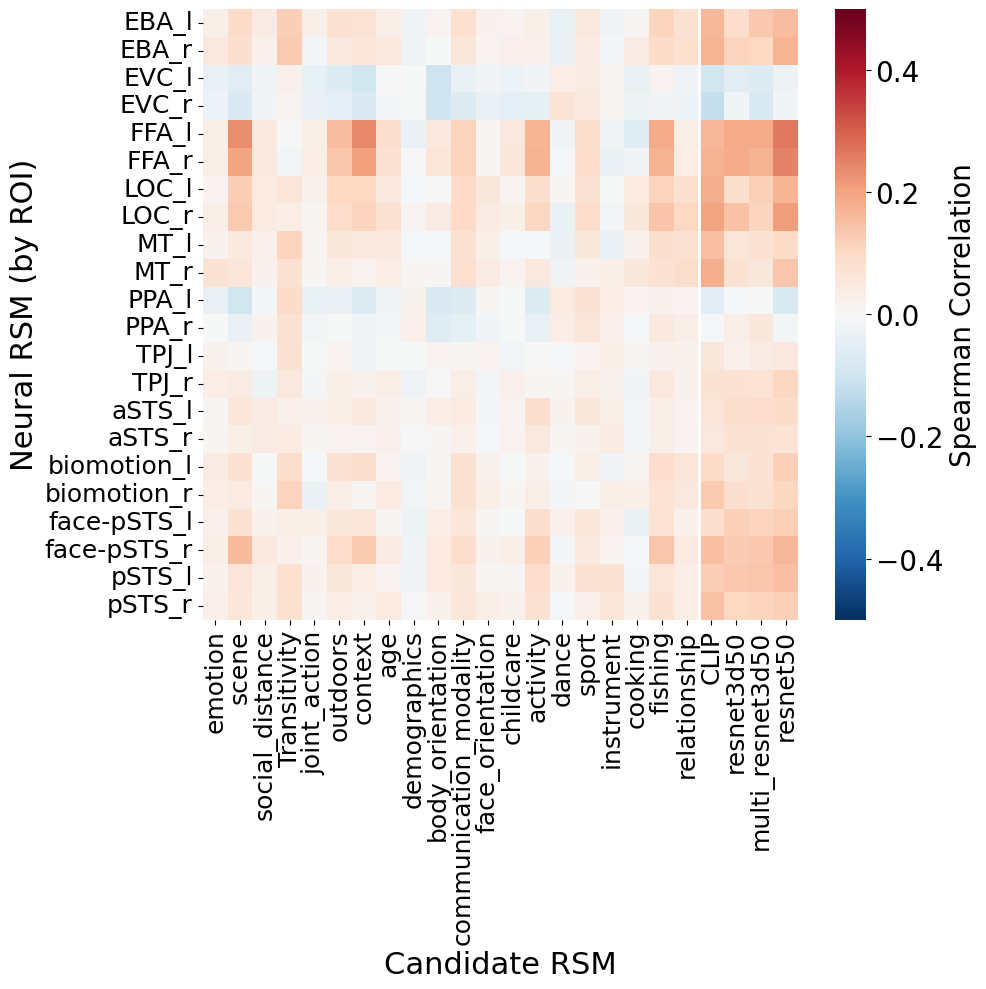

In [ ]:
#%% correlate candidate RSM with reorganized neural RSM for each subject/group

# Correlate each level with CLIP RSM and store results


# Correlate combined RSM with neural RSM for each subject/group
corr_dfs = {}
for level in roi_neural_rsm.keys():
    print(level)
    print(f'\nCorrelating {level} with combined RSM:')
    corr_df = correlate_dicts_asymmetric(roi_neural_rsm[level], combined_rsm,
                                 n_permutation=0,
                                 multiple_comparison='fdr_bh') 
    plot_heatmap_asymmetric(corr_df)
    corr_dfs[level] = corr_df

# Average correlation values across subjects (excluding group)
subject_dfs = [corr_dfs[level] for level in corr_dfs.keys() if level != 'group']
average_df = subject_dfs[0].copy()

# Calculate mean correlation values
for i in range(len(average_df)):
    r_values = [df.iloc[i]['r'] for df in subject_dfs]
    average_df.iloc[i, average_df.columns.get_loc('r')] = np.mean(r_values)
    
    # Use majority vote for significance
    sig_signs = [df.iloc[i]['sig_sign'] for df in subject_dfs]
    most_common_sign = max(set(sig_signs), key=sig_signs.count)
    average_df.iloc[i, average_df.columns.get_loc('sig_sign')] = most_common_sign

print('\nAverage correlation across subjects:')
plot_heatmap_asymmetric(average_df)